# Download MTA Data

MTA Turnstile Data : http://web.mta.info/developers/turnstile.html

In [1]:
reset -fs

Import Turnstile Data

I have used total 3 months of data from MTA data set to perform the ananlysis

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [3]:
engine = create_engine("sqlite:///mta_data.db")
df = pd.read_sql("SELECT * FROM mta_data", engine)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2732603 entries, 0 to 2732602
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 229.3+ MB


# Data Cleaning

 Column names , missing values and duplicates rows

In [5]:
#strip column name to remove the space between the column name
df.columns = [column.strip().lower(). replace('/','_')
for column in df.columns]
df.head()

,c_a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [6]:
df['date_time'] = pd.to_datetime(df['date'] + df['time'], format='%m/%d/%Y%H:%M:%S')

In [7]:
#look for missing values
df.isna().values.any() 
#looking for null values
df.isnull().sum()

c_a          0
unit         0
scp          0
station      0
linename     0
division     0
date         0
time         0
desc         0
entries      0
exits        0
date_time    0
dtype: int64

In [8]:
pre_size = len(df)
df.drop_duplicates(subset = ["c_a", "unit", "scp", "station", "date"])
pre_size, len(df)

(2732603, 2732603)

In [9]:
#create two new column to calculate the actual entries and exits
df[["prev_entries"]] = (df.groupby(["c_a", "unit", "scp", "station"])[["entries"]].shift(1))
df[["prev_exits"]] = (df.groupby(["c_a", "unit", "scp", "station"])[["exits"]].shift(1))

In [10]:
df.dropna(subset=["prev_entries"], axis=0, inplace=True)

In [11]:
# these are the column which shows the actual entries and exits
df["daily_exits"]=(df["exits"] - df["prev_exits"])
df["daily_entries"]=(df["entries"] - df["prev_entries"])
df['total_traffic'] = df.daily_entries + df.daily_exits
df.head()

,c_a,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time,prev_entries,prev_exits,daily_exits,daily_entries,total_traffic
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040,2021-12-18 07:00:00,7672966.0,2645023.0,17.0,3.0,20.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127,2021-12-18 11:00:00,7672969.0,2645040.0,87.0,22.0,109.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193,2021-12-18 15:00:00,7672991.0,2645127.0,66.0,46.0,112.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270,2021-12-18 19:00:00,7673037.0,2645193.0,77.0,60.0,137.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,23:00:00,REGULAR,7673128,2645283,2021-12-18 23:00:00,7673097.0,2645270.0,13.0,31.0,44.0


In [12]:
clean_mta = df[(df.daily_entries >= 0) & (df.daily_exits >= 0) & (df.total_traffic >= 0) & (df.total_traffic < 100000)]


In [13]:
# Again cleaning the data to avoid the abnormalities
(clean_mta
 .groupby(["c_a", "unit", "scp", "station", "date_time"])
 .total_traffic.count()
 .reset_index()
 .sort_values("total_traffic", ascending=False)).head(5)

,c_a,unit,scp,station,date_time,total_traffic
0,A002,R051,02-00-00,59 ST,2021-09-25 04:00:00,1
1758615,R142,R293,01-00-01,34 ST-PENN STA,2021-11-13 17:00:00,1
1758637,R142,R293,01-00-01,34 ST-PENN STA,2021-11-17 09:00:00,1
1758638,R142,R293,01-00-01,34 ST-PENN STA,2021-11-17 17:00:00,1
1758639,R142,R293,01-00-01,34 ST-PENN STA,2021-11-17 21:00:00,1


In [14]:
# Dropping Column "DESC" because it is not being used in this analysis
clean_mta = clean_mta.drop(["desc"], axis=1, errors="ignore")

In [15]:
# creating column to find day of week and hour
clean_mta['weekday'] = clean_mta['date_time'].dt.weekday
clean_mta['hour'] = clean_mta['date_time'].dt.hour
clean_mta.head(2)

,c_a,unit,scp,station,linename,division,date,time,entries,exits,date_time,prev_entries,prev_exits,daily_exits,daily_entries,total_traffic,weekday,hour
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,7672969,2645040,2021-12-18 07:00:00,7672966.0,2645023.0,17.0,3.0,20.0,5,7
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,7672991,2645127,2021-12-18 11:00:00,7672969.0,2645040.0,87.0,22.0,109.0,5,11


In [16]:
clean_mta['hour'] = clean_mta['date_time'].dt.hour
clean_mta.head(2)

,c_a,unit,scp,station,linename,division,date,time,entries,exits,date_time,prev_entries,prev_exits,daily_exits,daily_entries,total_traffic,weekday,hour
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,7672969,2645040,2021-12-18 07:00:00,7672966.0,2645023.0,17.0,3.0,20.0,5,7
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,7672991,2645127,2021-12-18 11:00:00,7672969.0,2645040.0,87.0,22.0,109.0,5,11


# Total traffic per station

Sorted the totat_traffic column in order to get the max value for each station

In [17]:
station_traffic = clean_mta.groupby("station")["total_traffic"].sum()\
        .reset_index()\
        .sort_values("total_traffic", ascending = False)
station_traffic.head()
top_10_station = station_traffic.head(n=10) # dataframe with top 10 stations
top_10_station

,station,total_traffic
61,34 ST-PENN STA,11728977.0
233,GRD CNTRL-42 ST,8821167.0
59,34 ST-HERALD SQ,8484716.0
14,14 ST-UNION SQ,7748571.0
110,86 ST,7697260.0
46,23 ST,7150309.0
353,TIMES SQ-42 ST,6889466.0
68,42 ST-PORT AUTH,6562692.0
9,125 ST,6258919.0
226,FULTON ST,6123507.0


# Import matplotlib 

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

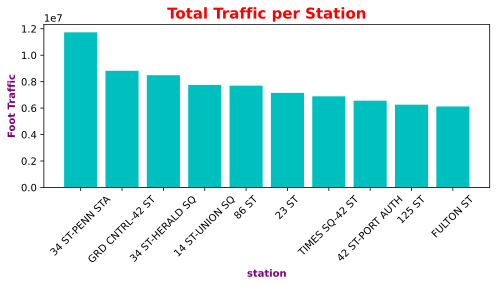

In [19]:
plt.figure(figsize=(8, 3))
plt.bar(top_10_station['station'], top_10_station['total_traffic'], color='c')
plt.ylabel('Foot Traffic',fontsize = 10, weight = 'bold',color='purple')
plt.xlabel('station',fontsize = 10, weight = 'bold',color='purple')
plt.xticks(rotation=45)
plt.title('Total Traffic per Station',family = 'sans-serif',weight ='bold', fontsize = 15,color = 'r');
plt.savefig('top_10_station', dpi=200,bbox_inches="tight")

# Average total traffic vs hours

The visiualization represents the average total traffic during peak hour

In [20]:
hourly_traffic = clean_mta.groupby("hour")["total_traffic"].mean().reset_index()

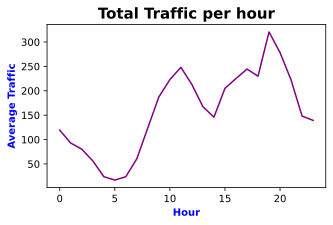

In [25]:
plt.figure(figsize=(5, 3))
plt.plot(hourly_traffic['hour'],hourly_traffic['total_traffic1'],color='purple')

plt.ylabel('Average Traffic',fontsize = 10, weight = 'bold',color='blue')
plt.xlabel('Hour',fontsize = 10, weight = 'bold',color='blue')

plt.title('Total Traffic per hour',family = 'sans-serif',fontsize = 15, weight = 'bold',color='black')
plt.savefig('hourlytraffic', dpi=200,bbox_inches="tight")

# hourly traffic for top 5 stations

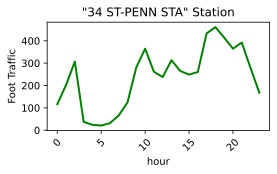

In [46]:
mask1 = clean_mta.station =="34 ST-PENN STA"
station_1 = clean_mta[mask1].groupby(["hour"]) ["total_traffic"].mean().reset_index()
plt.figure(figsize=(4, 2))
plt.plot(station_1['hour'],station_1['total_traffic'],color='green', lw=2)
plt.ylabel('Foot Traffic')
plt.xlabel('hour')
plt.xticks(rotation=45)
plt.title(f'"{"34 ST-PENN STA"}" Station')
plt.savefig('station1', dpi=200,bbox_inches="tight")

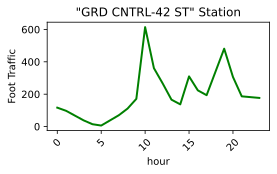

In [51]:
mask2 = clean_mta.station =="GRD CNTRL-42 ST"
station_2 = clean_mta[mask2].groupby(["hour"]) ["total_traffic"].mean().reset_index()
plt.figure(figsize=(4, 2))
plt.plot(station_2['hour'],station_2['total_traffic'],color='green', lw=2)
plt.ylabel('Foot Traffic')
plt.xlabel('hour')
plt.xticks(rotation=45)
plt.title(f'"{"GRD CNTRL-42 ST"}" Station')
plt.savefig('station2', dpi=200,bbox_inches="tight")

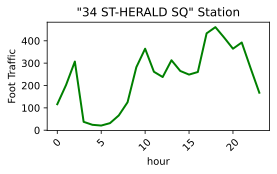

In [52]:
mask3 = clean_mta.station =="34 ST-HERALD SQ"
station_3 = clean_mta[mask1].groupby(["hour"]) ["total_traffic"].mean().reset_index()
plt.figure(figsize=(4, 2))
plt.plot(station_3['hour'],station_3['total_traffic'],color='green', lw=2)
plt.ylabel('Foot Traffic')
plt.xlabel('hour')
plt.xticks(rotation=45)
plt.title(f'"{"34 ST-HERALD SQ"}" Station')
plt.savefig('station3', dpi=200,bbox_inches="tight")

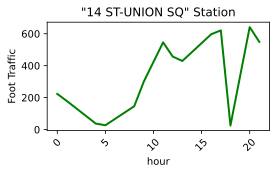

In [53]:
mask4 = clean_mta.station =="14 ST-UNION SQ"
station_4 = clean_mta[mask4].groupby(["hour"]) ["total_traffic"].mean().reset_index()
plt.figure(figsize=(4, 2))
plt.plot(station_4['hour'],station_4['total_traffic'],color='green', lw=2)
plt.ylabel('Foot Traffic')
plt.xlabel('hour')
plt.xticks(rotation=45)
plt.title(f'"{"14 ST-UNION SQ"}" Station')
plt.savefig('station4', dpi=200,bbox_inches="tight")

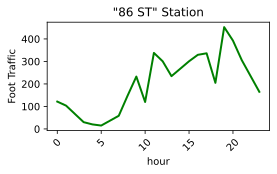

In [54]:
mask5 = clean_mta.station =="86 ST"
station_5 = clean_mta[mask5].groupby(["hour"]) ["total_traffic"].mean().reset_index()
plt.figure(figsize=(4, 2))
plt.plot(station_5['hour'],station_5['total_traffic'],color='green', lw=2)
plt.ylabel('Foot Traffic')
plt.xlabel('hour')
plt.xticks(rotation=45)
plt.title(f'"{"86 ST"}" Station')
plt.savefig('station5', dpi=200,bbox_inches="tight")

# Average total traffic vs hours

In [56]:
weekday_traffic = clean_mta.groupby("weekday")["total_traffic"].mean().reset_index()

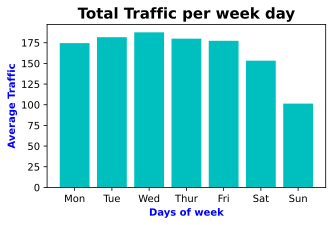

In [84]:
plt.figure(figsize=(5, 3))

days=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]  # I checked that monday is starting from index 0
plt.bar(days,weekday_traffic['total_traffic'], color='c');

plt.ylabel('Average Traffic',fontsize = 10, weight = 'bold',color='blue')
plt.xlabel('Days of week',fontsize = 10, weight = 'bold',color='blue')

plt.title('Total Traffic per week day',family = 'sans-serif',fontsize = 15, weight = 'bold',color='black')
plt.savefig('weekday_trafic', dpi=200,bbox_inches="tight")

# Average traffic over 7 days a week for top 5 stations

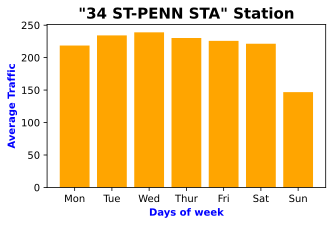

In [85]:
mask1 = clean_mta.station =="34 ST-PENN STA"
weekday_traffic1 = clean_mta[mask1].groupby(["weekday"]) ["total_traffic"].mean().reset_index()

plt.figure(figsize=(5, 3))
days=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
plt.bar(days,weekday_traffic1['total_traffic'],color='orange', lw=2)

plt.ylabel('Average Traffic',fontsize = 10, weight = 'bold',color='blue')
plt.xlabel('Days of week',fontsize = 10, weight = 'bold',color='blue')


plt.title(f'"{"34 ST-PENN STA"}" Station', family = 'sans-serif',fontsize = 15, weight = 'bold',color='black')
plt.savefig('weekday_traffic1', dpi=200,bbox_inches="tight")

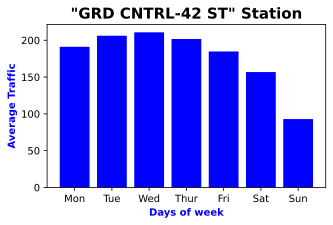

In [86]:
mask2 = clean_mta.station =="GRD CNTRL-42 ST"
weekday_traffic2 = clean_mta[mask2].groupby(["weekday"]) ["total_traffic"].mean().reset_index()

plt.figure(figsize=(5, 3))
days=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
plt.bar(days,weekday_traffic2['total_traffic'],color='blue', lw=2)

plt.ylabel('Average Traffic',fontsize = 10, weight = 'bold',color='blue')
plt.xlabel('Days of week',fontsize = 10, weight = 'bold',color='blue')


plt.title(f'"{"GRD CNTRL-42 ST"}" Station', family = 'sans-serif',fontsize = 15, weight = 'bold',color='black')
plt.savefig('weekday_traffic2', dpi=200,bbox_inches="tight")

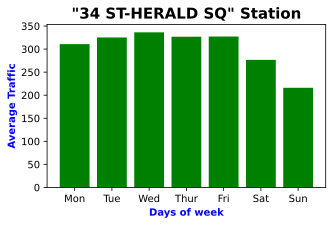

In [78]:
mask3 = clean_mta.station =="34 ST-HERALD SQ"
weekday_traffic3 = clean_mta[mask3].groupby(["weekday"]) ["total_traffic"].mean().reset_index()

plt.figure(figsize=(5, 3))
days=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
plt.bar(days,weekday_traffic3['total_traffic'],color='green', lw=2)

plt.ylabel('Average Traffic',fontsize = 10, weight = 'bold',color='blue')
plt.xlabel('Days of week',fontsize = 10, weight = 'bold',color='blue')


plt.title(f'"{"34 ST-HERALD SQ"}" Station', family = 'sans-serif',fontsize = 15, weight = 'bold',color='black')
plt.savefig('weekday_traffic3', dpi=200,bbox_inches="tight")

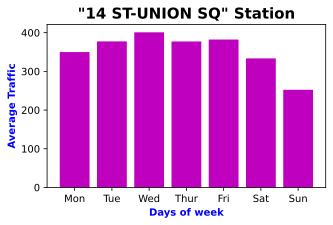

In [87]:
mask4 = clean_mta.station =="14 ST-UNION SQ"
weekday_traffic4 = clean_mta[mask4].groupby(["weekday"]) ["total_traffic"].mean().reset_index()

plt.figure(figsize=(5, 3))
days=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
plt.bar(days,weekday_traffic4['total_traffic'],color='m', lw=2)

plt.ylabel('Average Traffic',fontsize = 10, weight = 'bold',color='blue')
plt.xlabel('Days of week',fontsize = 10, weight = 'bold',color='blue')


plt.title(f'"{"14 ST-UNION SQ"}" Station', family = 'sans-serif',fontsize = 15, weight = 'bold',color='black')
plt.savefig('weekday_traffic4', dpi=200,bbox_inches="tight")

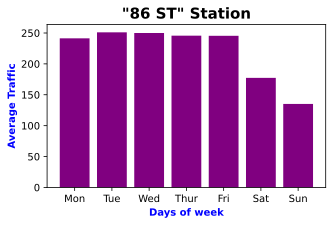

In [88]:
mask5 = clean_mta.station =="86 ST"
weekday_traffic5 = clean_mta[mask5].groupby(["weekday"]) ["total_traffic"].mean().reset_index()

plt.figure(figsize=(5, 3))
days=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
plt.bar(days,weekday_traffic5['total_traffic'],color='purple', lw=2)

plt.ylabel('Average Traffic',fontsize = 10, weight = 'bold',color='blue')
plt.xlabel('Days of week',fontsize = 10, weight = 'bold',color='blue')


plt.title(f'"{"86 ST"}" Station', family = 'sans-serif',fontsize = 15, weight = 'bold',color='black')
plt.savefig('weekday_traffic5', dpi=200,bbox_inches="tight")

# Method for plotting the top 10 busiest station (average traffic vs hour)

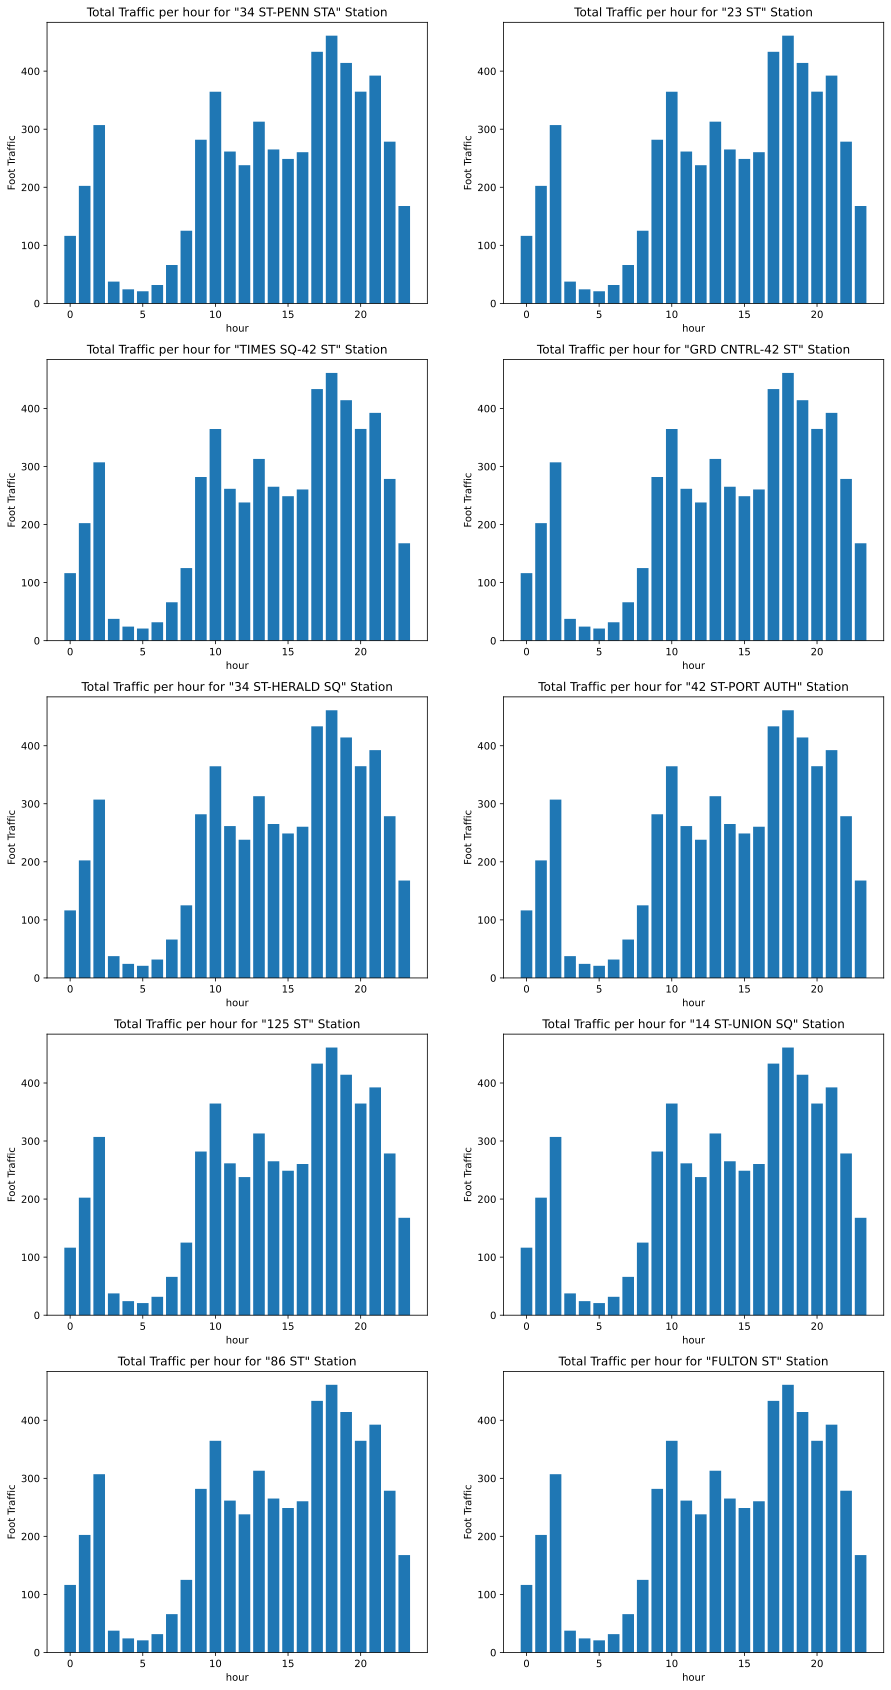

In [91]:
#function which takes the list of top 10 station and plot the hourly graph for each station
def plot_peak_hours(stations):
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))

    i = 0
    for x in stations:
        mask = clean_mta.station == x # look for the name of station in Clean_mta data frame
        station_1 = clean_mta[mask1].groupby(["hour"]) ["total_traffic"].mean().reset_index()
        axs[i%5, i%2].bar(station_1['hour'],station_1['total_traffic'])
        axs[i%5, i%2].set_title(f'Total Traffic per hour for "{x}" Station')
        i += 1

    for ax in axs.flat:
        ax.set(xlabel='hour', ylabel='Foot Traffic')

top_stations = top_10_station.station.to_numpy().tolist()

plot_peak_hours(top_stations)

# Method for plotting the top 10 busiest station (average traffic VS days of week)


These methods can be used for further analysis, where it takes the list of top 10 station names and plots the traffic vs days of week graphs

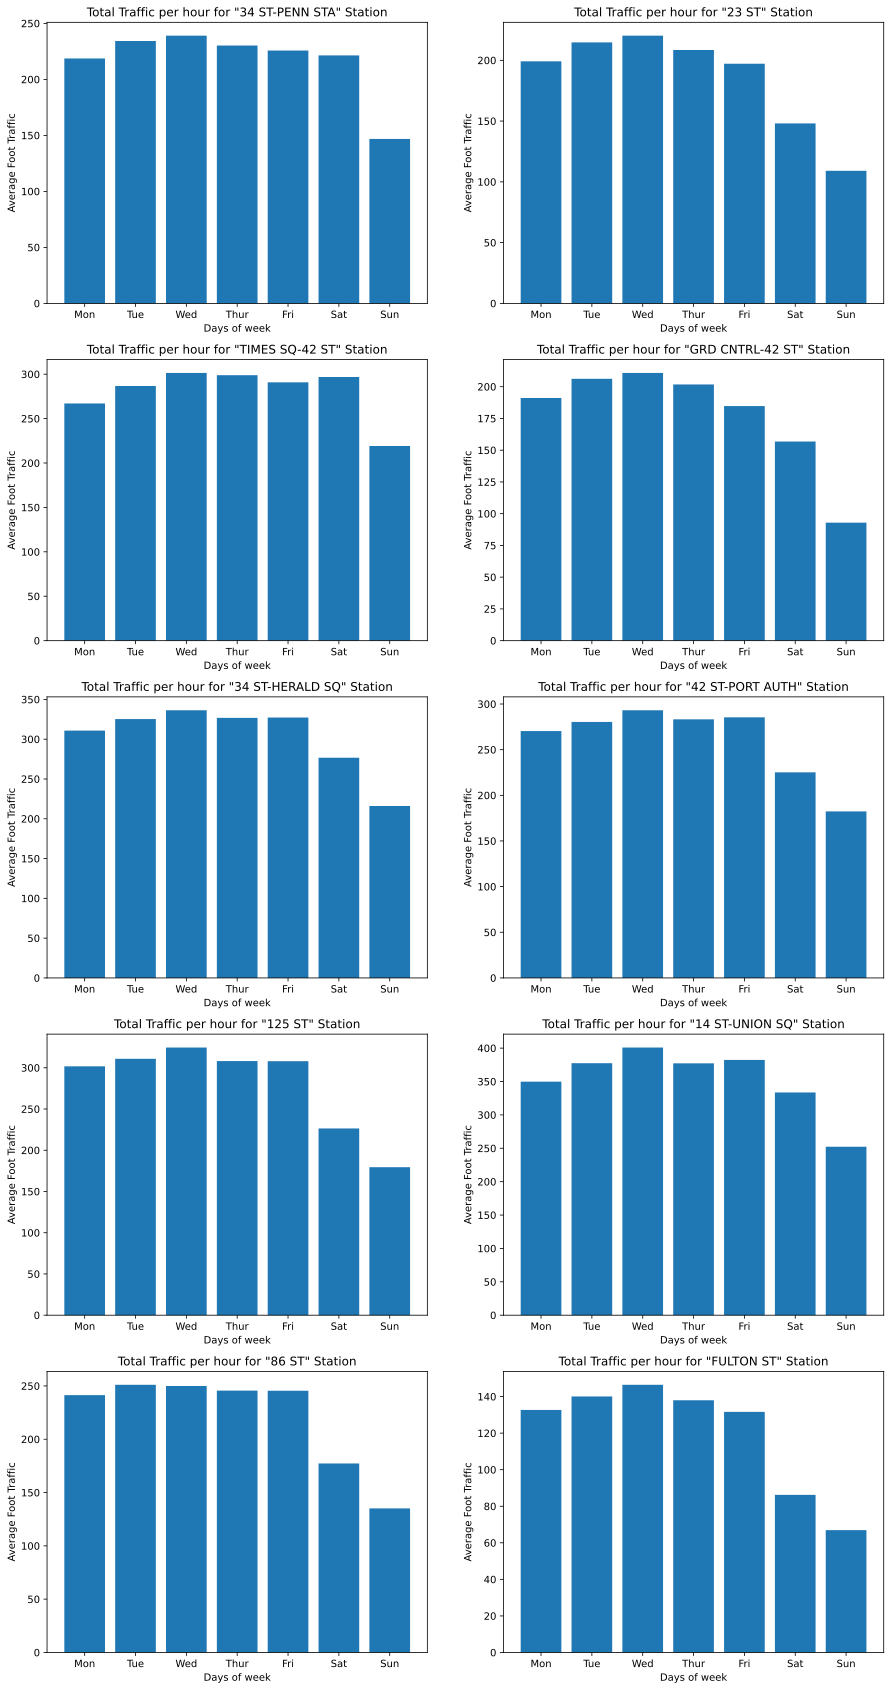

In [92]:
def peak_weekdays(stations):
    
    fig, axs = plt.subplots(5,2,figsize=(15,30))
    i=0
    for x in stations:
        mask = clean_mta.station == x  # look for the name of station in Clean_mta data frame
        station_1 = clean_mta[mask].groupby(["weekday"]) ["total_traffic"].mean().reset_index()
        
        days=["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]
        
        axs[i%5, i%2].bar(days,station_1['total_traffic'])
        axs[i%5, i%2].set_title(f'Total Traffic per hour for "{x}" Station')
        i+=1
        
    for ax in axs.flat: 
        ax.set(xlabel='Days of week',ylabel='Average Foot Traffic')
        
    
    
top_stations = top_10_station.station.to_numpy().tolist()

peak_weekdays(top_stations)